In [1]:
import wandb

wandb.login()

wandb: Currently logged in as: hooda-saksham (sakshamshooda). Use `wandb login --relogin` to force relogin


True

In [2]:
wandb.init(
    project='qa_project',
    name='t5_samll_qa_run_main2'
)    

In [3]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('cleaned_data.csv')

In [5]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

# Prepare the data for T5 model
def convert_to_t5_format(df):
    df['input_text'] = "question: " + df['question'] + " </s>"
    df['target_text'] = df['answer'] + " </s>"
    return df[['input_text', 'target_text']]

train_df = convert_to_t5_format(train_df)
val_df = convert_to_t5_format(val_df)

In [8]:
from transformers import T5Tokenizer
import torch
from torch.utils.data import Dataset

# Initialize the tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')

# Custom Dataset class
class QADataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=512):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        question = str(self.data.iloc[index]['input_text'])
        answer = str(self.data.iloc[index]['target_text'])

        # Encode the inputs and targets
        input_encodings = self.tokenizer(question, truncation=True, padding='max_length', max_length=self.max_len, return_tensors="pt")
        target_encodings = self.tokenizer(answer, truncation=True, padding='max_length', max_length=self.max_len, return_tensors="pt")

        input_ids = input_encodings['input_ids'].squeeze()
        attention_mask = input_encodings['attention_mask'].squeeze()
        labels = target_encodings['input_ids'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

# Create datasets
train_dataset = QADataset(train_df, tokenizer)
val_dataset = QADataset(val_df, tokenizer)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
from transformers import T5ForConditionalGeneration, Trainer, TrainingArguments

# Initialize the T5 model
model = T5ForConditionalGeneration.from_pretrained('t5-small')

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=3,
    logging_dir='./logs',
    report_to="wandb",
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()


Epoch,Training Loss,Validation Loss
1,1.305700,1.236404
2,1.307600,1.220926
3,1.282300,1.216898


/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:303: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:303: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:303: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:303: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:30

TrainOutput(global_step=18624, training_loss=1.3225552626082169, metrics={'train_runtime': 3918.9195, 'train_samples_per_second': 38.018, 'train_steps_per_second': 4.752, 'total_flos': 2.016443965951181e+16, 'train_loss': 1.3225552626082169, 'epoch': 3.0})

T5 Evaluation from saved model

In [1]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
from datasets import load_metric
import numpy as np
import torch
from torch.utils.data import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split

df=pd.read_csv('cleaned_data.csv')

# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

# Prepare the data for T5 model
def convert_to_t5_format(df):
    df['input_text'] = "question: " + df['question'] + " </s>"
    df['target_text'] = df['answer'] + " </s>"
    return df[['input_text', 'target_text']]

train_df = convert_to_t5_format(train_df)
val_df = convert_to_t5_format(val_df)

2024-07-31 11:45:03.688245: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 11:45:03.688310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 11:45:03.689289: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 11:45:03.695062: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-31 11:45:04.570427: W tensorflow/compiler/tf2

In [5]:
# Path to the saved model
saved_model_path = 'results/checkpoint-18500'

# Load the saved model and tokenizer
print(f"Loading model from {saved_model_path}...")
model = T5ForConditionalGeneration.from_pretrained(saved_model_path)
model.to(device)
tokenizer = T5Tokenizer.from_pretrained('t5-small')
print("Model loaded.")

Loading model from results/checkpoint-18500...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Model loaded.


In [6]:
# Custom Dataset class
class QADataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=512):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        question = str(self.data.iloc[index]['input_text'])
        answer = str(self.data.iloc[index]['target_text'])

        # Encode the inputs and targets
        input_encodings = self.tokenizer(question, truncation=True, padding='max_length', max_length=self.max_len, return_tensors="pt")
        target_encodings = self.tokenizer(answer, truncation=True, padding='max_length', max_length=self.max_len, return_tensors="pt")

        input_ids = input_encodings['input_ids'].squeeze()
        attention_mask = input_encodings['attention_mask'].squeeze()
        labels = target_encodings['input_ids'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

# Create datasets
train_dataset = QADataset(train_df, tokenizer)
val_dataset = QADataset(val_df, tokenizer)


In [7]:
# Function to generate predictions
def generate_predictions(dataset):
    model.eval()
    predictions = []
    for i in range(len(dataset)):
        data = dataset[i]
        input_ids = data['input_ids'].unsqueeze(0).to(model.device)
        attention_mask = data['attention_mask'].unsqueeze(0).to(model.device)
        output = model.generate(input_ids, attention_mask=attention_mask, max_length=50)
        prediction = tokenizer.decode(output[0], skip_special_tokens=True)
        predictions.append(prediction)
        if i < 5:  # Debug: Print first 5 predictions
            print(f"Prediction {i+1}: {prediction}")
    return predictions

# Generate predictions on the validation set
print("Generating predictions on the validation set...")
val_predictions = generate_predictions(val_dataset)
print("Predictions generated.")

# Extract references from the validation DataFrame
print("Extracting references from the validation set...")
references = val_df['target_text'].tolist()
print(f"References extracted: {references[:5]}")  # Debug: Print first 5 references

Generating predictions on the validation set...


/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:303: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


Prediction 1: atom is a great tool for creating a visual studio code that is a great tool for creating a visual studio code that is a great tool for creating a visual studio code that is a great tool for creating
Prediction 2: i think he is a trump and he is a trump he is a trump he is a trump he is a trump he is a
Prediction 3: i have a rolex submariner with a suit andor blazer with a suit andor blazer
Prediction 4: vfa val vaq is a vfa val vaq vfa val vaq is a vfa val vaq vfa val vaq is a
Prediction 5: i have been working on a course for a few years and i have been working on a course for a few years and i have been working on a course for a few years and i have been
Predictions generated.
Extracting references from the validation set...
References extracted: ['vs code when building a complete project i don’t find the point of using sublime like why settle for less when you can get more features and improve your productivity vs code is equally good as an ide can be made if not other 

In [17]:
#additional debugging step
# Ensure all predictions and references are strings
val_predictions = [str(pred) for pred in val_predictions]
references = [str(ref) for ref in references]

# Check for any unexpected data types
for i, (pred, ref) in enumerate(zip(val_predictions, references)):
    if not isinstance(pred, str) or not isinstance(ref, str):
        print(f"Unexpected type at index {i}: pred type = {type(pred)}, ref type = {type(ref)}")


In [19]:
import evaluate
print("Calculating BLEU score...")
# BLEU Score
bleu_metric = load_metric('bleu')
bleu_score = bleu_metric.compute(predictions=[pred.split() for pred in val_predictions], references=[[ref.split()] for ref in references])
print(f"BLEU Score: {bleu_score}")

Calculating BLEU score...
BLEU Score: {'bleu': 0.0003568087726723466, 'precisions': [0.26394942402966476, 0.04400221394787159, 0.011278415939639951, 0.004318559669113175], 'brevity_penalty': 0.013010379178733204, 'length_ratio': 0.18719553202311823, 'translation_length': 164505, 'reference_length': 878787}


In [10]:
print("Calculating ROUGE score...")
# ROUGE Score
rouge_metric = load_metric('rouge')
rouge_score = rouge_metric.compute(predictions=val_predictions, references=references)
print(f"ROUGE Score: {rouge_score}")

Calculating ROUGE score...
ROUGE Score: {'rouge1': AggregateScore(low=Score(precision=0.2600345001310784, recall=0.08743182620750192, fmeasure=0.10313585721300668), mid=Score(precision=0.2659813447335798, recall=0.08952145968963707, fmeasure=0.10513936671095758), high=Score(precision=0.2719797652831562, recall=0.09163947740887345, fmeasure=0.1071410185989546)), 'rouge2': AggregateScore(low=Score(precision=0.04228656027236747, recall=0.0120663660046332, fmeasure=0.014938135421813032), mid=Score(precision=0.04463947709171807, recall=0.012767124575040902, fmeasure=0.015729537240531638), high=Score(precision=0.04685418491530742, recall=0.01353547548974515, fmeasure=0.01651259723641572)), 'rougeL': AggregateScore(low=Score(precision=0.21156954386954002, recall=0.07496707100751669, fmeasure=0.08597689491559886), mid=Score(precision=0.21616155984656932, recall=0.07680124851211581, fmeasure=0.08743322163833483), high=Score(precision=0.2204371639758323, recall=0.07856986194518846, fmeasure=0.08

In [28]:
def compute_f1(predictions, references):
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    num_samples = len(predictions)
    
    for pred, ref in zip(predictions, references):
        pred_tokens = pred.split()
        ref_tokens = ref.split()
        common_tokens = set(pred_tokens) & set(ref_tokens)
        if len(pred_tokens) == 0 or len(ref_tokens) == 0:
            precision = 0
            recall = 0
            f1 = 0
        else:
            precision = len(common_tokens) / len(pred_tokens)
            recall = len(common_tokens) / len(ref_tokens)
            if precision + recall == 0:
                f1 = 0
            else:
                f1 = 2 * (precision * recall) / (precision + recall)
        
        total_precision += precision
        total_recall += recall
        total_f1 += f1
        
        # Debug: Print precision, recall, and F1 score for the first 5 samples
        if num_samples <= 5:
            print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
    
    avg_precision = total_precision / num_samples
    avg_recall = total_recall / num_samples
    avg_f1 = total_f1 / num_samples
    
    return avg_precision, avg_recall, avg_f1

avg_precision, avg_recall, avg_f1 = compute_f1(val_predictions, references)
print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")
print(f"Average F1 Score: {avg_f1}")

Average Precision: 0.13991480188444438
Average Recall: 0.056443834525255615
Average F1 Score: 0.06215999146584162


**BLEU Scores**

| Metric                     | Score     |
|----------------------------|-----------|
| BLEU                       | 0.000357  |
| BLEU Precision 1           | 0.263949  |
| BLEU Precision 2           | 0.044002  |
| BLEU Precision 3           | 0.011278  |
| BLEU Precision 4           | 0.004319  |
| BLEU Brevity Penalty       | 0.013010  |
| BLEU Length Ratio          | 0.187196  |
| BLEU Translation Length    | 164505    |
| BLEU Reference Length      | 878787    |

**ROUGE Scores**
| Metric                     | Score     |
|----------------------------|-----------|
| ROUGE-1 Precision (low)    | 0.260035  |
| ROUGE-1 Precision (mid)    | 0.265981  |
| ROUGE-1 Precision (high)   | 0.271980  |
| ROUGE-1 Recall (low)       | 0.087432  |
| ROUGE-1 Recall (mid)       | 0.089521  |
| ROUGE-1 Recall (high)      | 0.091639  |
| ROUGE-1 F1 (low)           | 0.103136  |
| ROUGE-1 F1 (mid)           | 0.105139  |
| ROUGE-1 F1 (high)          | 0.107141  |
| ROUGE-2 Precision (low)    | 0.042287  |
| ROUGE-2 Precision (mid)    | 0.044639  |
| ROUGE-2 Precision (high)   | 0.046854  |
| ROUGE-2 Recall (low)       | 0.012066  |
| ROUGE-2 Recall (mid)       | 0.012767  |
| ROUGE-2 Recall (high)      | 0.013535  |
| ROUGE-2 F1 (low)           | 0.014938  |
| ROUGE-2 F1 (mid)           | 0.015730  |
| ROUGE-2 F1 (high)          | 0.016513  |
| ROUGE-L Precision (low)    | 0.211570  |
| ROUGE-L Precision (mid)    | 0.216162  |
| ROUGE-L Precision (high)   | 0.220437  |
| ROUGE-L Recall (low)       | 0.074967  |
| ROUGE-L Recall (mid)       | 0.076801  |
| ROUGE-L Recall (high)      | 0.078570  |
| ROUGE-L F1 (low)           | 0.085977  |
| ROUGE-L F1 (mid)           | 0.087433  |
| ROUGE-L F1 (high)          | 0.088995  |
| ROUGE-Lsum Precision (low) | 0.211322  |
| ROUGE-Lsum Precision (mid) | 0.215879  |
| ROUGE-Lsum Precision (high)| 0.220419  |
| ROUGE-Lsum Recall (low)    | 0.074760  |
| ROUGE-Lsum Recall (mid)    | 0.076733  |
| ROUGE-Lsum Recall (high)   | 0.078608  |
| ROUGE-Lsum F1 (low)        | 0.085782  |
| ROUGE-Lsum F1 (mid)        | 0.087351  |
| ROUGE-Lsum F1 (high)       | 0.088962  |

**F1/classification scores**
| Metric             | Score     |
|--------------------|-----------|
| Average Precision  | 0.139915  |
| Average Recall     | 0.056444  |
| Average F1 Score   | 0.062160  |


In [3]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyo

# Initialize notebook mode
pyo.init_notebook_mode(connected=True)

# BLEU Scores
bleu_scores = {
    "Metric": ["BLEU", "BLEU Precision 1", "BLEU Precision 2", "BLEU Precision 3", "BLEU Precision 4", 
               "BLEU Brevity Penalty", "BLEU Length Ratio", "BLEU Translation Length", "BLEU Reference Length"],
    "Score": [0.000357, 0.263949, 0.044002, 0.011278, 0.004319, 0.013010, 0.187196, 164505, 878787]
}

# ROUGE Scores
rouge_scores = {
    "Metric": ["ROUGE-1 Precision (low)", "ROUGE-1 Precision (mid)", "ROUGE-1 Precision (high)",
               "ROUGE-1 Recall (low)", "ROUGE-1 Recall (mid)", "ROUGE-1 Recall (high)",
               "ROUGE-1 F1 (low)", "ROUGE-1 F1 (mid)", "ROUGE-1 F1 (high)",
               "ROUGE-2 Precision (low)", "ROUGE-2 Precision (mid)", "ROUGE-2 Precision (high)",
               "ROUGE-2 Recall (low)", "ROUGE-2 Recall (mid)", "ROUGE-2 Recall (high)",
               "ROUGE-2 F1 (low)", "ROUGE-2 F1 (mid)", "ROUGE-2 F1 (high)",
               "ROUGE-L Precision (low)", "ROUGE-L Precision (mid)", "ROUGE-L Precision (high)",
               "ROUGE-L Recall (low)", "ROUGE-L Recall (mid)", "ROUGE-L Recall (high)",
               "ROUGE-L F1 (low)", "ROUGE-L F1 (mid)", "ROUGE-L F1 (high)",
               "ROUGE-Lsum Precision (low)", "ROUGE-Lsum Precision (mid)", "ROUGE-Lsum Precision (high)",
               "ROUGE-Lsum Recall (low)", "ROUGE-Lsum Recall (mid)", "ROUGE-Lsum Recall (high)",
               "ROUGE-Lsum F1 (low)", "ROUGE-Lsum F1 (mid)", "ROUGE-Lsum F1 (high)"],
    "Score": [0.260035, 0.265981, 0.271980, 0.087432, 0.089521, 0.091639, 
              0.103136, 0.105139, 0.107141, 0.042287, 0.044639, 0.046854, 
              0.012066, 0.012767, 0.013535, 0.014938, 0.015730, 0.016513, 
              0.211570, 0.216162, 0.220437, 0.074967, 0.076801, 0.078570, 
              0.085977, 0.087433, 0.088995, 0.211322, 0.215879, 0.220419, 
              0.074760, 0.076733, 0.078608, 0.085782, 0.087351, 0.088962]
}

# F1/classification scores
f1_scores = {
    "Metric": ["Average Precision", "Average Recall", "Average F1 Score"],
    "Score": [0.139915, 0.056444, 0.062160]
}

# Plot BLEU Scores
fig_bleu = px.bar(bleu_scores, x="Metric", y="Score", title="BLEU Scores")
fig_bleu.update_layout(xaxis_tickangle=-45)

# Plot ROUGE Scores
fig_rouge = px.bar(rouge_scores, x="Metric", y="Score", title="ROUGE Scores")
fig_rouge.update_layout(xaxis_tickangle=-45)

# Plot F1 Scores
fig_f1 = px.bar(f1_scores, x="Metric", y="Score", title="F1/Classification Scores")

# Show plots
pyo.iplot(fig_bleu)
pyo.iplot(fig_rouge)
pyo.iplot(fig_f1)


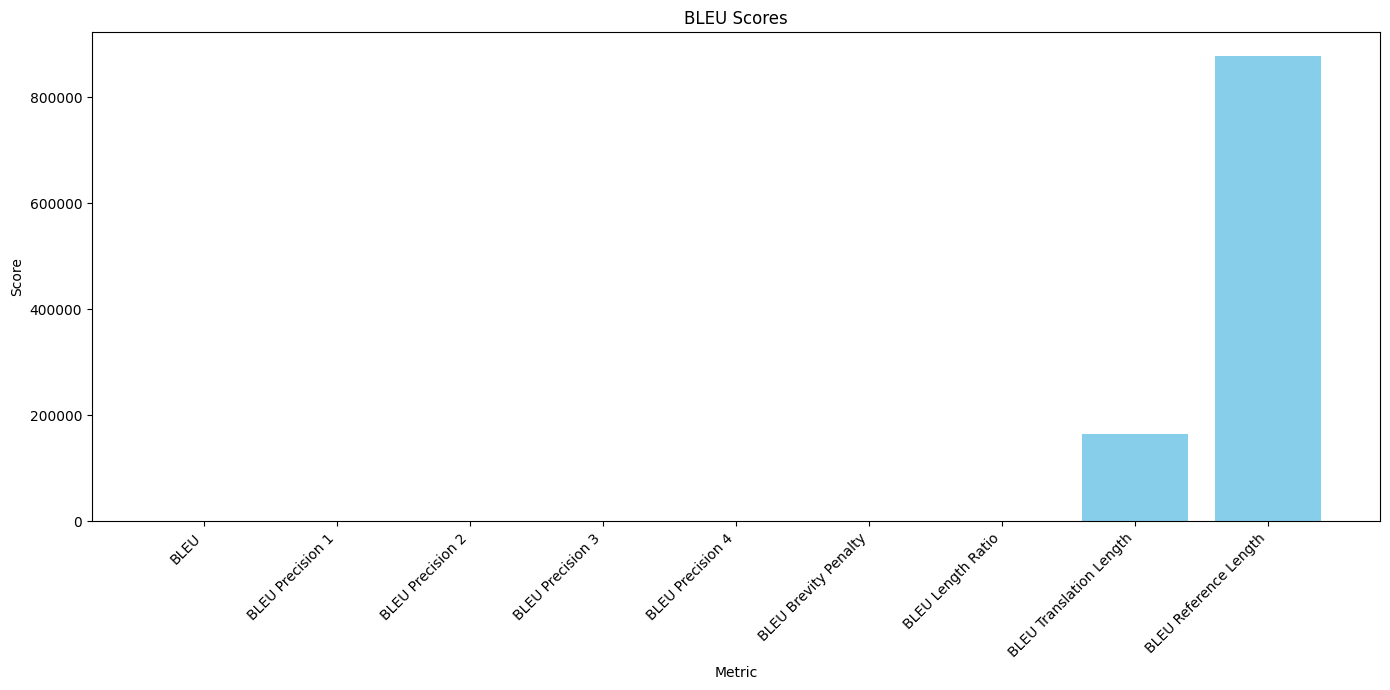

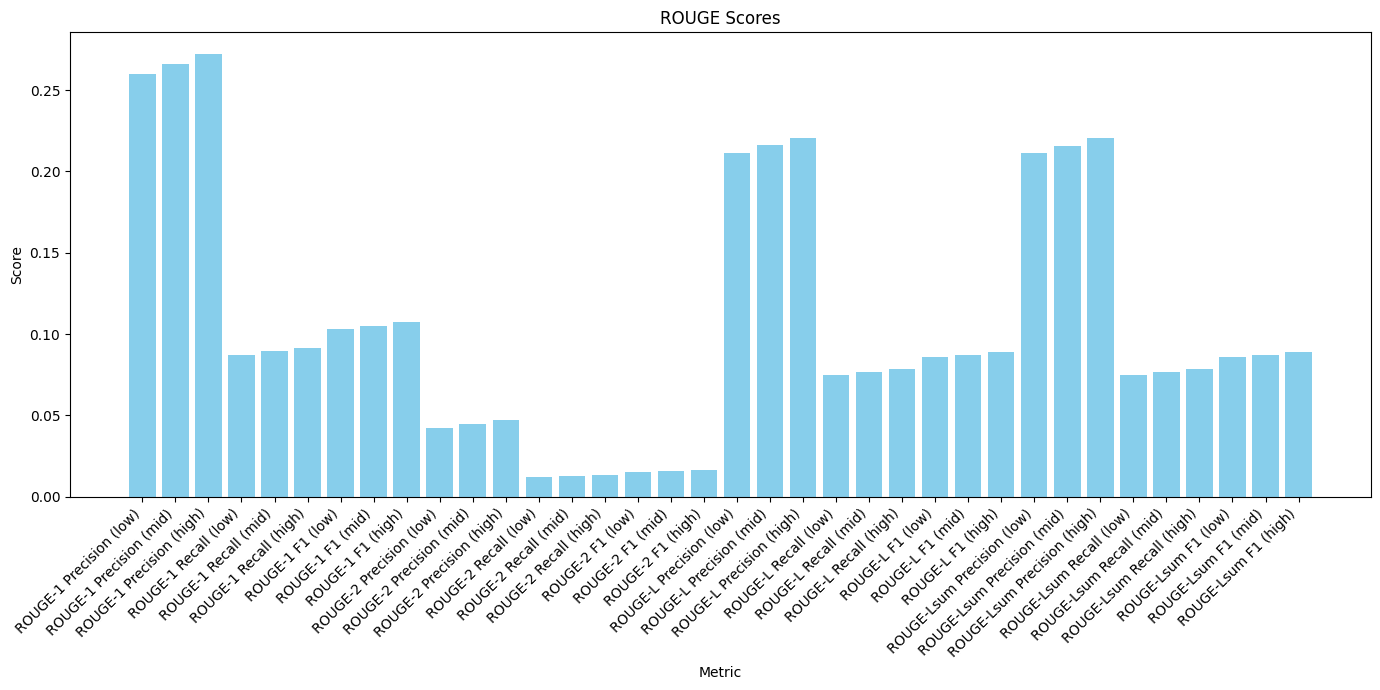

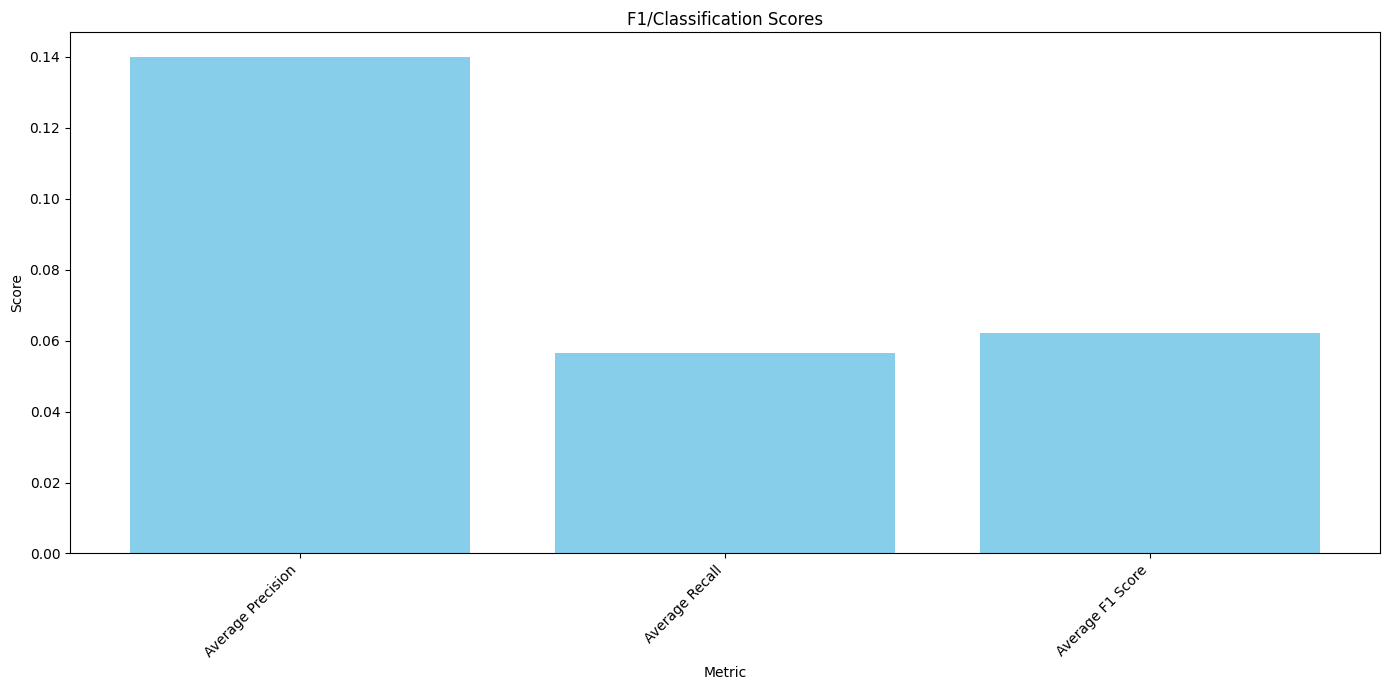

In [4]:
import matplotlib.pyplot as plt

# BLEU Scores
bleu_scores = {
    "Metric": ["BLEU", "BLEU Precision 1", "BLEU Precision 2", "BLEU Precision 3", "BLEU Precision 4", 
               "BLEU Brevity Penalty", "BLEU Length Ratio", "BLEU Translation Length", "BLEU Reference Length"],
    "Score": [0.000357, 0.263949, 0.044002, 0.011278, 0.004319, 0.013010, 0.187196, 164505, 878787]
}

# ROUGE Scores
rouge_scores = {
    "Metric": ["ROUGE-1 Precision (low)", "ROUGE-1 Precision (mid)", "ROUGE-1 Precision (high)",
               "ROUGE-1 Recall (low)", "ROUGE-1 Recall (mid)", "ROUGE-1 Recall (high)",
               "ROUGE-1 F1 (low)", "ROUGE-1 F1 (mid)", "ROUGE-1 F1 (high)",
               "ROUGE-2 Precision (low)", "ROUGE-2 Precision (mid)", "ROUGE-2 Precision (high)",
               "ROUGE-2 Recall (low)", "ROUGE-2 Recall (mid)", "ROUGE-2 Recall (high)",
               "ROUGE-2 F1 (low)", "ROUGE-2 F1 (mid)", "ROUGE-2 F1 (high)",
               "ROUGE-L Precision (low)", "ROUGE-L Precision (mid)", "ROUGE-L Precision (high)",
               "ROUGE-L Recall (low)", "ROUGE-L Recall (mid)", "ROUGE-L Recall (high)",
               "ROUGE-L F1 (low)", "ROUGE-L F1 (mid)", "ROUGE-L F1 (high)",
               "ROUGE-Lsum Precision (low)", "ROUGE-Lsum Precision (mid)", "ROUGE-Lsum Precision (high)",
               "ROUGE-Lsum Recall (low)", "ROUGE-Lsum Recall (mid)", "ROUGE-Lsum Recall (high)",
               "ROUGE-Lsum F1 (low)", "ROUGE-Lsum F1 (mid)", "ROUGE-Lsum F1 (high)"],
    "Score": [0.260035, 0.265981, 0.271980, 0.087432, 0.089521, 0.091639, 
              0.103136, 0.105139, 0.107141, 0.042287, 0.044639, 0.046854, 
              0.012066, 0.012767, 0.013535, 0.014938, 0.015730, 0.016513, 
              0.211570, 0.216162, 0.220437, 0.074967, 0.076801, 0.078570, 
              0.085977, 0.087433, 0.088995, 0.211322, 0.215879, 0.220419, 
              0.074760, 0.076733, 0.078608, 0.085782, 0.087351, 0.088962]
}

# F1/classification scores
f1_scores = {
    "Metric": ["Average Precision", "Average Recall", "Average F1 Score"],
    "Score": [0.139915, 0.056444, 0.062160]
}

# Function to plot bar charts
def plot_bar_chart(data, title):
    plt.figure(figsize=(14, 7))
    plt.bar(data["Metric"], data["Score"], color='skyblue')
    plt.title(title)
    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot BLEU Scores
plot_bar_chart(bleu_scores, "BLEU Scores")

# Plot ROUGE Scores
plot_bar_chart(rouge_scores, "ROUGE Scores")

# Plot F1 Scores
plot_bar_chart(f1_scores, "F1/Classification Scores")


In [ ]:
wandb.finish()